In [310]:
import warnings
warnings.filterwarnings("ignore")
import pickle as pk
import pandas as pd
import wordcloud as wc
import gensim as gs
import gensim.corpora as cp
import pyLDAvis.gensim
import pyLDAvis
import numpy as np
import  matplotlib.pyplot as plt

In [311]:
covid_date = np.datetime64('2020-04-01T01:00:00.000000+0100')
n_topics = 10

# WordCloud

In [312]:
def word_cloud(df):
    all_words = ''
    for text in df['text']:
        all_words += ','.join(list(text)) 
        
    print('Total words {}'.format(len(all_words)))
    
    wordcloud = wc.WordCloud(background_color="white", max_words=100000, contour_width=4, scale=3, contour_color='steelblue')
    wordcloud.generate(all_words)
    return wordcloud.to_image()

# LDA

In [313]:
def lda(df, n_topics=5):
    all_words = []
    for text in df['text']:
        all_words.append(text)
    
    # Create dictionary and corpus
    word2num = cp.Dictionary(all_words)
    texts = all_words
    
    # Get term frequency
    corpus = [word2num.doc2bow(text) for text in texts]
    
    lda_model = gs.models.LdaMulticore(corpus=corpus, id2word=word2num, num_topics=n_topics)
    doc_lda = lda_model[corpus]
    
    print('\nTopics')
    print(lda_model.print_topics())
    
    print('\nScores')
    for i in range(0, len(corpus), 500):
        for index, score in sorted(lda_model[corpus[i]], key=lambda tup: -1*tup[1]):
            print("\nScore: {}\t \nTopic: {}".format(score, lda_model.print_topic(index, 10)))
    
    pyLDAvis.enable_notebook()
    return pyLDAvis.gensim.prepare(lda_model, corpus, word2num)

def lda_base(df, n_topics=5):
    all_words = []
    for text in df['text']:
        all_words.append(text)
    
    # Create dictionary and corpus
    word2num = cp.Dictionary(all_words)
    texts = all_words
    
    # Get term frequency
    corpus = [word2num.doc2bow(text) for text in texts]
    
    lda_model = gs.models.LdaMulticore(corpus=corpus, id2word=word2num, num_topics=n_topics)
    doc_lda = lda_model[corpus]
    
    print('\nTopics')
    print(lda_model.print_topics())
    
    print('\nScores')
    for i in range(0, len(corpus), 500):
        for index, score in sorted(lda_model[corpus[i]], key=lambda tup: -1*tup[1]):
            print("\nScore: {}\t \nTopic: {}".format(score, lda_model.print_topic(index, 10)))
    
    pyLDAvis.enable_notebook()
    return (lda_model, corpus, word2num)

# All

In [314]:
# Need to first get cleaned tokenized text data
uber_df_tk = pd.read_pickle(r'./data/uber_tk.p')

In [320]:
users=set(list(uber_df_tk['source'])+list(uber_df_tk['target']))
users = [user.lower() for user in users]

In [370]:
# from nltk.tokenize import sent_tokenize, word_tokenize
# from nltk.corpus import stopwords
# from nltk.stem import WordNetLemmatizer

# word_lemmatizer = WordNetLemmatizer()

#Get rid of handles
for i in uber_df_tk.index:
    source=uber_df_tk['source'][i].lower().replace("_","")
    target=uber_df_tk['target'][i].lower().replace("_","")
    text=uber_df_tk['text'][i]
    word_tokenize(str(text).lower().replace("'",""))
    while(source in text):
        index=text.index(source)
        del text[index]
    while(target in text):
        index=text.index(target)
        del text[index] 
    while("uber" in text):
        index=text.index("uber")
        del text[index] 
    while("httpubersupport" in text):
        index=text.index("httpubersupport")
        del text[index] 
    while("ubersupport" in text):
        index=text.index("ubersupport")
        del text[index] 
    uber_df_tk['text'][i]=text

In [374]:
import pickle
pickle.dump(uber_df_tk,open('./data/uber_tk.p','wb'))

In [372]:

wcloud = word_cloud(uber_df_tk)

Total words 289077


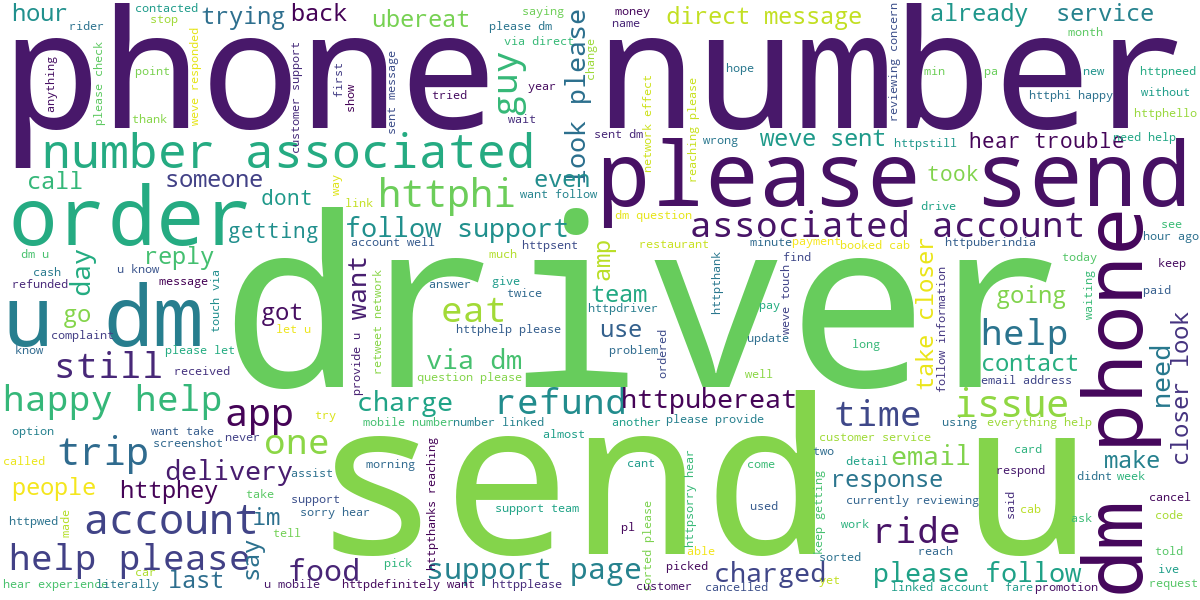

In [373]:
wcloud

In [305]:
agg=pd.read_csv("./data/all_aggregated_uber_results_2.csv")

In [212]:
alltopics=pd.DataFrame()
no_topics=10
for corp in corpus:
    topic_stuff=pd.DataFrame(lda_model[corp])
    topic=topic_stuff.T.iloc[1]
    topic.index=topic_stuff.T.iloc[0]

    actual_topic=topic_stuff.sort_values(by=1).tail(1)
    actual_topic=actual_topic[0][actual_topic.index[0]]
    topic=pd.DataFrame(topic.T).T.reset_index(drop=True)
    topic['Topic']=actual_topic
    # topic=topic_stuff.T.iloc[1].append(pd.Series(actual_topic)).reset_index(drop=True)
    alltopics=alltopics.append(topic,ignore_index=True)

In [214]:
alltopics=alltopics.fillna(0)

In [236]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
SIA = SentimentIntensityAnalyzer()
sentiments=[]
for topic in alltopics.index:
    negativity = SIA.polarity_scores(" ".join(uber_df_tk['text'][topic]))['neg']
    sentiments.append(negativity)

In [238]:
uber_df_tk['sentiments']=sentiments

In [249]:
convos=[]
for index in uber_df_tk.index:
    convo=" ".join(sorted([uber_df_tk['source'][index],uber_df_tk['target'][index]]))
    convos.append(convo)

In [251]:
uber_df_tk['Convo']=convos

In [259]:
unique_convos=set(convos)

In [282]:
# all_sentdifferences=[]
all_sents=[]
for convo in unique_convos:
    involved=uber_df_tk[uber_df_tk['Convo']==convo].reset_index(drop=True)
#     sent=0
#     sentdifferences=[sent]
    sents=[]
    for i in involved.index:
#         sentdiff = sent-involved['sentiments'][i]
#         sent=involved['sentiments'][i]
#         sentdifferences.append(sentdiff)
        sents.append(involved['sentiments'][i])
    all_sents.append(sents)
#     all_sentdifferences.append(sentdifferences)

In [288]:
all_sents_df=pd.DataFrame(all_sents)

In [285]:
convo_sents=pd.DataFrame(zip(unique_convos,all_sents))

In [303]:
convo_sents[convo_sents[0].str.contains('StlGig')]

,0,1
914,StlGig dkhos,"[0.0, 0.0, 0.314, 0.0]"
1603,StlGig TODAYshow,[0.0]
2551,CNN StlGig,[0.0]
2642,StlGig ksdknews,[0.0]
2987,StlGig Uber_Support,"[0.0, 0.0, 0.314, 0.0]"


<BarContainer object of 22 artists>

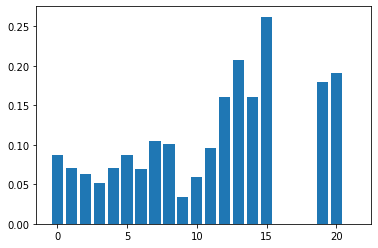

In [300]:
means=all_sents_df.mean()
plt.bar(means.index,means)

In [228]:
pd.concat([uber_df_tk[['source','target','type_of_content','created_at']],alltopics],axis=1).to_csv("formatted.csv")

In [10]:
pyLDAvis.save_html(LDAvis_prepared,'./html/all_lda_n{}.html'.format(n_topics))

C:\Users\18199\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# To Uber

In [9]:
to_uber_df_tk = uber_df_tk[uber_df_tk['target'] == 'Uber_Support']

In [12]:
to_uber_df_tk

C:\Users\18199\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,source,source_id,target,target_id,type_of_content,created_at,all_data,text
4,SatishInnov8,722043526461145088,Uber_Support,2815754953,Reply,2019-12-09 17:11:51,{'created_at': 'Mon Dec 09 17:11:51 +0000 2019...,"[ubersupport, wish, respectfully, state, regul..."
15,James_Carleton,247005181,Uber_Support,2815754953,Reply,2019-12-28 03:34:47,{'created_at': 'Sat Dec 28 03:34:47 +0000 2019...,"[ubersupport, ubereats, mcdonaldscanada, hi, t..."
18,SajeshSreejayan,96289683,Uber_Support,2815754953,Reply,2019-12-28 06:53:00,{'created_at': 'Sat Dec 28 06:53:00 +0000 2019...,"[ubersupport, awesome, partner, asks, destinat..."
19,iVigneshSuresh,59047875,Uber_Support,2815754953,Reply,2019-12-28 09:56:17,{'created_at': 'Sat Dec 28 09:56:17 +0000 2019...,"[ubersupport, ubersupport, uberindia, apart, s..."
20,iVigneshSuresh,59047875,Uber_Support,2815754953,Reply,2019-12-28 09:56:17,{'created_at': 'Sat Dec 28 09:56:17 +0000 2019...,"[ubersupport, ubersupport, uberindia, apart, s..."
...,...,...,...,...,...,...,...,...
5562,Iam_bahuguna,1094093461631000576,Uber_Support,2815754953,Reply,2021-03-31 17:09:05,{'created_at': 'Wed Mar 31 17:09:05 +0000 2021...,"[ubersupport, refused, move, even, minute, ask..."
5563,ajb_neuk,1344742630731747328,Uber_Support,2815754953,Reply,2021-03-31 17:15:48,{'created_at': 'Wed Mar 31 17:15:48 +0000 2021...,"[ubersupport, yeah, cause, link, useful, suppo..."
5564,AdrianMatache7,1376698104028794882,Uber_Support,2815754953,Reply,2021-03-31 17:18:34,{'created_at': 'Wed Mar 31 17:18:34 +0000 2021...,"[ubersupport, hi, guy, long, take, bank, accou..."
5565,k_sovs,1369169148580823040,Uber_Support,2815754953,Reply,2021-03-31 17:19:01,{'created_at': 'Wed Mar 31 17:19:01 +0000 2021...,"[ubersupport, filled, form, many, time, response]"


In [13]:
wcloud = word_cloud(to_uber_df_tk)

C:\Users\18199\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Total words 202701


C:\Users\18199\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


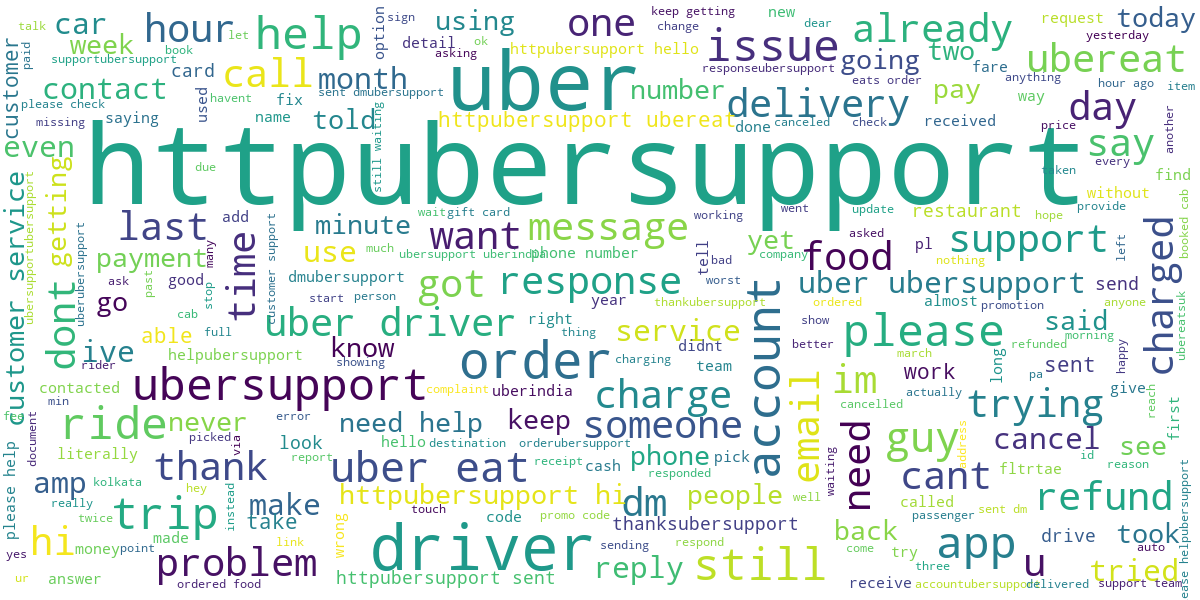

In [14]:
wcloud

In [15]:
LDAvis_prepared = lda(to_uber_df_tk, n_topics=n_topics)

C:\Users\18199\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Topics
[(0, '0.116*"ubersupport" + 0.060*"http" + 0.037*"uber" + 0.014*"account" + 0.014*"driver" + 0.009*"order" + 0.009*"get" + 0.009*"still" + 0.008*"ride" + 0.008*"please"'), (1, '0.101*"ubersupport" + 0.049*"http" + 0.036*"uber" + 0.017*"order" + 0.012*"contact" + 0.011*"trip" + 0.010*"sent" + 0.010*"help" + 0.008*"get" + 0.007*"need"'), (2, '0.107*"ubersupport" + 0.060*"http" + 0.021*"driver" + 0.018*"uber" + 0.014*"hi" + 0.013*"dm" + 0.011*"please" + 0.010*"ubereats" + 0.007*"guy" + 0.006*"support"'), (3, '0.081*"ubersupport" + 0.050*"http" + 0.013*"help" + 0.011*"order" + 0.011*"driver" + 0.008*"uber" + 0.008*"hour" + 0.007*"app" + 0.007*"account" + 0.006*"yet"'), (4, '0.105*"ubersupport" + 0.077*"http" + 0.029*"uber" + 0.016*"driver" + 0.014*"help" + 0.012*"please" + 0.010*"issue" + 0.009*"need" + 0.008*"app" + 0.007*"order"'), (5, '0.070*"ubersupport" + 0.037*"http" + 0.016*"uber" + 0.013*"order" + 0.012*"guy" + 0.009*"account" + 0.009*"keep" + 0.008*"support" + 0.008*"issue

In [30]:
LDAvis_prepared[3]

30

In [17]:
pyLDAvis.save_html(LDAvis_prepared,'./html/to_lda_n{}.html'.format(n_topics))

C:\Users\18199\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# From Uber

In [18]:
from_uber_df_tk = uber_df_tk[uber_df_tk['source'] == 'Uber_Support']

C:\Users\18199\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [19]:
from_uber_df_tk

C:\Users\18199\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,source,source_id,target,target_id,type_of_content,created_at,all_data,text
0,Uber_Support,2815754953,wordofbrandon,2566081240,Reply,2019-08-31 10:53:53,{'created_at': 'Sat Aug 31 10:53:53 +0000 2019...,"[wordofbrandon, thanks, bringing, attention, w..."
1,Uber_Support,2815754953,wordofbrandon,2566081240,Reply,2019-08-31 10:53:53,{'created_at': 'Sat Aug 31 10:53:53 +0000 2019...,"[wordofbrandon, thanks, bringing, attention, w..."
2,Uber_Support,2815754953,CapeVgirl,719534538,Reply,2019-10-01 07:45:30,{'created_at': 'Tue Oct 01 07:45:30 +0000 2019...,"[capevgirl, help, suggest, restarting, app, wo..."
3,Uber_Support,2815754953,CapeVgirl,719534538,Reply,2019-10-01 07:45:30,{'created_at': 'Tue Oct 01 07:45:30 +0000 2019...,"[capevgirl, help, suggest, restarting, app, wo..."
5,Uber_Support,2815754953,realchetty,28766827,Reply,2019-12-20 12:02:54,{'created_at': 'Fri Dec 20 12:02:54 +0000 2019...,"[realchetty, definitely, want, ensure, address..."
...,...,...,...,...,...,...,...,...
5551,Uber_Support,2815754953,CVREENSWORLD,1352048476339761153,Reply,2021-03-31 16:54:36,{'created_at': 'Wed Mar 31 16:54:36 +0000 2021...,"[cvreensworld, hi, cvreeny, happy, help, pleas..."
5552,Uber_Support,2815754953,makaylabez,303867642,Reply,2021-03-31 16:55:35,{'created_at': 'Wed Mar 31 16:55:35 +0000 2021...,"[makaylabez, happy, help, makayla, please, sen..."
5553,Uber_Support,2815754953,ajb_neuk,1344742630731747328,Reply,2021-03-31 16:55:49,{'created_at': 'Wed Mar 31 16:55:49 +0000 2021...,"[ajbneuk, hi, happy, help, please, follow, sup..."
5554,Uber_Support,2815754953,Nezz911,429610920,Reply,2021-03-31 16:57:30,{'created_at': 'Wed Mar 31 16:57:30 +0000 2021...,"[hi, neo, assist]"


In [20]:
wcloud = word_cloud(from_uber_df_tk)

C:\Users\18199\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Total words 81444


C:\Users\18199\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


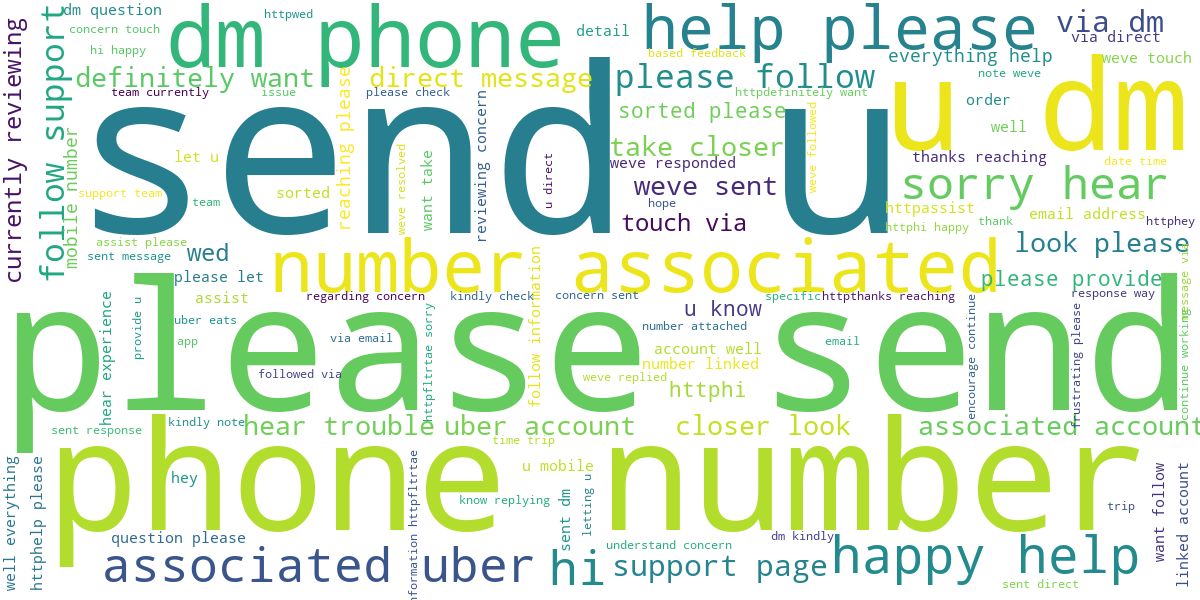

In [21]:
wcloud

In [33]:
LDAvis_prepared = lda(from_uber_df_tk, n_topics=n_topics)

NameError: name 'from_uber_df_tk' is not defined

In [24]:
pyLDAvis.save_html(LDAvis_prepared,'./html/from_lda_n{}.html'.format(n_topics))

C:\Users\18199\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# To Uber Pre-COVID

In [25]:
pre_to_uber_df_tk = uber_df_tk[(uber_df_tk['target'] == 'Uber_Support') & (uber_df_tk['created_at'] <= covid_date)]

C:\Users\18199\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [26]:
pre_to_uber_df_tk

C:\Users\18199\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,source,source_id,target,target_id,type_of_content,created_at,all_data,text
4,SatishInnov8,722043526461145088,Uber_Support,2815754953,Reply,2019-12-09 17:11:51,{'created_at': 'Mon Dec 09 17:11:51 +0000 2019...,"[ubersupport, wish, respectfully, state, regul..."
15,James_Carleton,247005181,Uber_Support,2815754953,Reply,2019-12-28 03:34:47,{'created_at': 'Sat Dec 28 03:34:47 +0000 2019...,"[ubersupport, ubereats, mcdonaldscanada, hi, t..."
18,SajeshSreejayan,96289683,Uber_Support,2815754953,Reply,2019-12-28 06:53:00,{'created_at': 'Sat Dec 28 06:53:00 +0000 2019...,"[ubersupport, awesome, partner, asks, destinat..."
19,iVigneshSuresh,59047875,Uber_Support,2815754953,Reply,2019-12-28 09:56:17,{'created_at': 'Sat Dec 28 09:56:17 +0000 2019...,"[ubersupport, ubersupport, uberindia, apart, s..."
20,iVigneshSuresh,59047875,Uber_Support,2815754953,Reply,2019-12-28 09:56:17,{'created_at': 'Sat Dec 28 09:56:17 +0000 2019...,"[ubersupport, ubersupport, uberindia, apart, s..."
...,...,...,...,...,...,...,...,...
655,ImAndreM,283383158,Uber_Support,2815754953,Reply,2019-12-31 23:27:48,{'created_at': 'Tue Dec 31 23:27:48 +0000 2019...,"[ubersupport, uber, eats, order, stuck, hour, ..."
656,Bigmanpfc,21190526,Uber_Support,2815754953,Reply,2019-12-31 23:31:15,{'created_at': 'Tue Dec 31 23:31:15 +0000 2019...,"[ubersupport, ask, different, wife, tweeted, r..."
657,hegemonprime,286568999,Uber_Support,2815754953,Reply,2019-12-31 23:51:09,{'created_at': 'Tue Dec 31 23:51:09 +0000 2019...,"[ubersupport, hey, trying, update, platform, i..."
658,jstocks21,1619318929,Uber_Support,2815754953,Reply,2019-12-31 23:51:59,{'created_at': 'Tue Dec 31 23:51:59 +0000 2019...,"[ubersupport, response, gotten, everyone, one,..."


In [27]:
wcloud = word_cloud(pre_to_uber_df_tk)

C:\Users\18199\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Total words 33251


C:\Users\18199\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


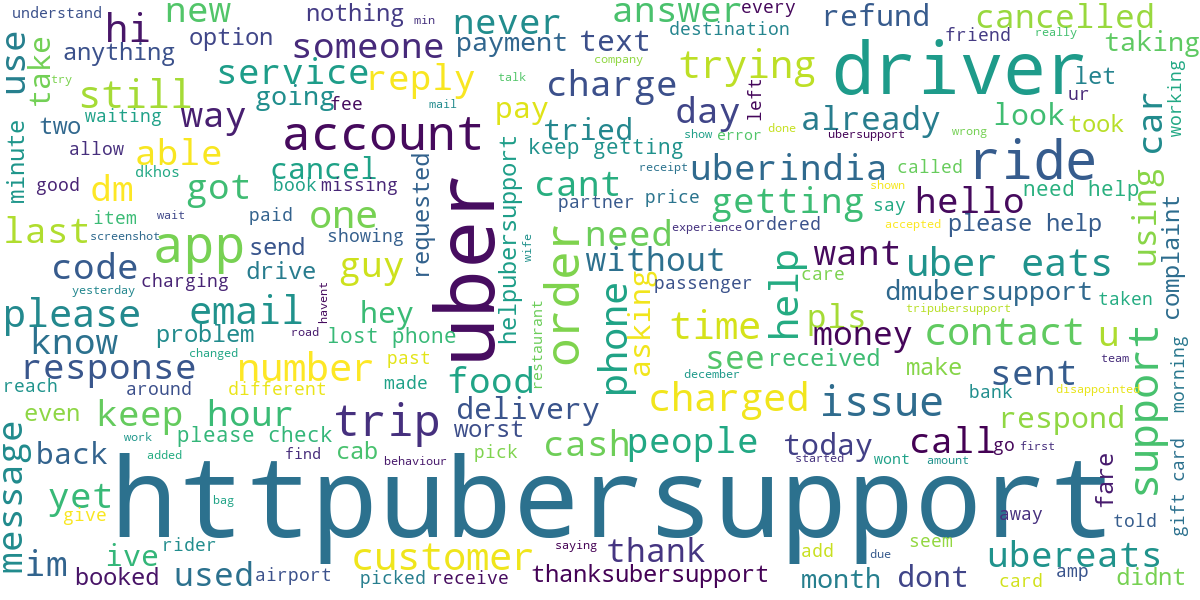

In [28]:
wcloud

In [29]:
LDAvis_prepared = lda(pre_to_uber_df_tk, n_topics=n_topics)

C:\Users\18199\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Topics
[(0, '0.050*"ubersupport" + 0.013*"http" + 0.013*"answer" + 0.013*"money" + 0.013*"issue" + 0.009*"driver" + 0.009*"help" + 0.009*"around" + 0.009*"rider" + 0.009*"refuse"'), (1, '0.100*"ubersupport" + 0.059*"http" + 0.018*"uber" + 0.018*"driver" + 0.012*"ride" + 0.011*"please" + 0.008*"app" + 0.008*"order" + 0.008*"contact" + 0.008*"help"'), (2, '0.051*"ubersupport" + 0.023*"uber" + 0.023*"http" + 0.016*"driver" + 0.015*"trying" + 0.013*"phone" + 0.013*"order" + 0.011*"u" + 0.008*"eats" + 0.008*"connect"'), (3, '0.073*"ubersupport" + 0.036*"http" + 0.035*"uber" + 0.011*"get" + 0.011*"support" + 0.011*"ride" + 0.010*"time" + 0.009*"help" + 0.009*"app" + 0.009*"phone"'), (4, '0.070*"ubersupport" + 0.035*"http" + 0.035*"uber" + 0.016*"account" + 0.013*"driver" + 0.009*"help" + 0.009*"trip" + 0.009*"service" + 0.008*"number" + 0.008*"able"'), (5, '0.070*"ubersupport" + 0.043*"http" + 0.027*"uber" + 0.020*"driver" + 0.009*"code" + 0.008*"app" + 0.008*"cash" + 0.007*"payment" + 0.00

In [30]:
LDAvis_prepared

C:\Users\18199\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.063203 -0.046536       1        1  32.477266
6      0.048422 -0.058079       2        1  21.485916
3      0.109274  0.052090       3        1   9.141706
4     -0.014448 -0.063964       4        1   7.021308
5     -0.049413 -0.003575       5        1   6.731012
7     -0.032853  0.002760       6        1   6.597266
9     -0.049276 -0.055175       7        1   5.200508
8      0.014739  0.066062       8        1   4.855875
2     -0.030951  0.057855       9        1   3.937993
0     -0.058698  0.048562      10        1   2.551149, topic_info=            Term        Freq       Total Category  logprob  loglift
8    ubersupport  385.000000  385.000000  Default   30.000  30.0000
7           uber  115.000000  115.000000  Default   29.000  29.0000
1           http  251.000000  251.000000  Default   28.000  28.0000
121       driver   75.000000   75.000000  Default   27.000  27.0000
69       account   33.000000   33.000000  Default   26.000  26.0000
..           ...         ...         ...      ...      ...      ...
67        thanks    0.567219   11.950860  Topic10   -5.375   0.6208
17            hi    0.567207   19.004487  Topic10   -5.375   0.1569
54           add    0.567203    5.288852  Topic10   -5.375   1.4360
184         card    0.567202    9.061201  Topic10   -5.375   0.8976
55          code    0.567198   11.138148  Topic10   -5.375   0.6912

[648 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
385       1  0.095289   able
385       2  0.190579   able
385       3  0.190579   able
385       4  0.285868   able
385       6  0.190579   able
...     ...       ...    ...
702       2  0.292358    yet
702       4  0.097453    yet
702       5  0.097453    yet
702       8  0.097453    yet
781       4  0.686920  youre

[1043 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 7, 4, 5, 6, 8, 10, 9, 3, 1])

In [31]:
pyLDAvis.save_html(LDAvis_prepared,'./html/pre_to_lda_n{}.html'.format(n_topics))

C:\Users\18199\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# To Uber Post-COVID

In [32]:
post_to_uber_df_tk = uber_df_tk[(uber_df_tk['target'] == 'Uber_Support') & (uber_df_tk['created_at'] > covid_date)]

C:\Users\18199\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [33]:
post_to_uber_df_tk

C:\Users\18199\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,source,source_id,target,target_id,type_of_content,created_at,all_data,text
690,Arshdee12667790,1324955159395356672,Uber_Support,2815754953,Reply,2020-12-29 02:49:31,{'created_at': 'Tue Dec 29 02:49:31 +0000 2020...,"[ubersupport, used, work, southaustralia, move..."
695,AbdulRa10911356,1343811137159258112,Uber_Support,2815754953,Reply,2020-12-29 07:14:44,{'created_at': 'Tue Dec 29 07:14:44 +0000 2020...,"[ubersupport, sir, issue, driver, app, please,..."
696,AbdulRa10911356,1343811137159258112,Uber_Support,2815754953,Reply,2020-12-29 07:17:23,{'created_at': 'Tue Dec 29 07:17:23 +0000 2020...,"[ubersupport, driver, app, issue, please, help]"
699,ZaidAmir7,37367374,Uber_Support,2815754953,Reply,2020-12-29 08:36:09,{'created_at': 'Tue Dec 29 08:36:09 +0000 2020...,"[ubersupport, yeah, got, response, show, read,..."
700,ZaidAmir7,37367374,Uber_Support,2815754953,Reply,2020-12-29 08:37:44,{'created_at': 'Tue Dec 29 08:37:44 +0000 2020...,"[ubersupport, someone, somewhere, else, talk, ..."
...,...,...,...,...,...,...,...,...
5562,Iam_bahuguna,1094093461631000576,Uber_Support,2815754953,Reply,2021-03-31 17:09:05,{'created_at': 'Wed Mar 31 17:09:05 +0000 2021...,"[ubersupport, refused, move, even, minute, ask..."
5563,ajb_neuk,1344742630731747328,Uber_Support,2815754953,Reply,2021-03-31 17:15:48,{'created_at': 'Wed Mar 31 17:15:48 +0000 2021...,"[ubersupport, yeah, cause, link, useful, suppo..."
5564,AdrianMatache7,1376698104028794882,Uber_Support,2815754953,Reply,2021-03-31 17:18:34,{'created_at': 'Wed Mar 31 17:18:34 +0000 2021...,"[ubersupport, hi, guy, long, take, bank, accou..."
5565,k_sovs,1369169148580823040,Uber_Support,2815754953,Reply,2021-03-31 17:19:01,{'created_at': 'Wed Mar 31 17:19:01 +0000 2021...,"[ubersupport, filled, form, many, time, response]"


In [34]:
wcloud = word_cloud(from_uber_df_tk)

C:\Users\18199\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Total words 81444


C:\Users\18199\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


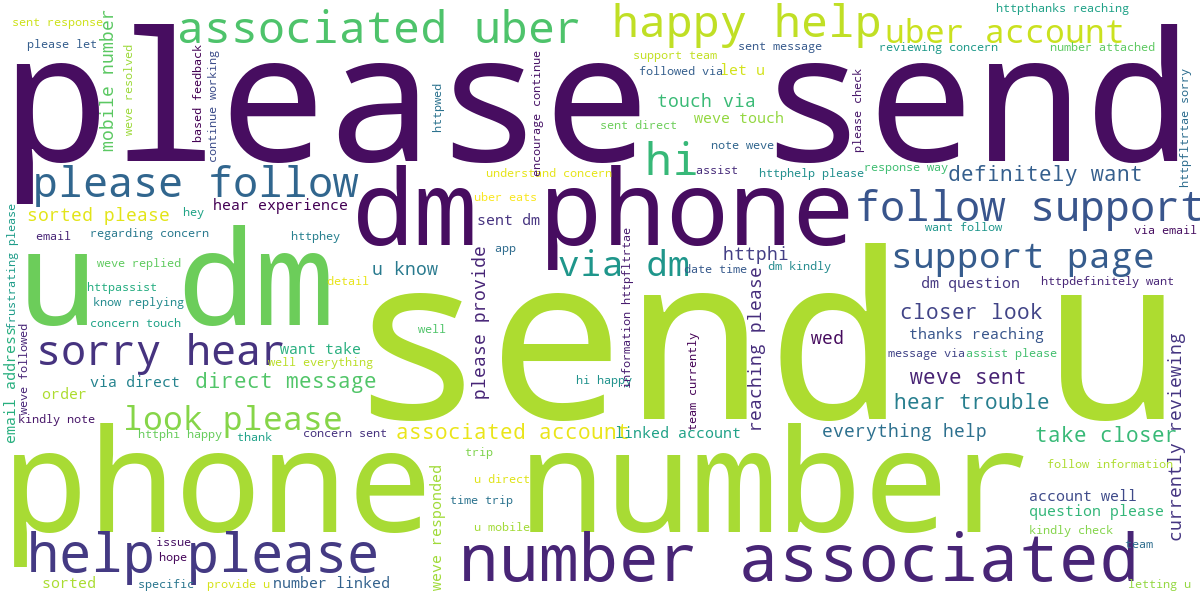

In [35]:
wcloud

In [36]:
LDAvis_prepared = lda(post_to_uber_df_tk, n_topics=n_topics)

C:\Users\18199\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Topics
[(0, '0.088*"ubersupport" + 0.023*"uber" + 0.022*"http" + 0.016*"need" + 0.014*"help" + 0.012*"dm" + 0.009*"food" + 0.009*"support" + 0.008*"driver" + 0.008*"still"'), (1, '0.080*"ubersupport" + 0.065*"uber" + 0.061*"http" + 0.016*"driver" + 0.007*"please" + 0.006*"service" + 0.006*"uberindia" + 0.005*"response" + 0.005*"want" + 0.005*"said"'), (2, '0.113*"ubersupport" + 0.065*"http" + 0.037*"uber" + 0.017*"help" + 0.016*"driver" + 0.011*"order" + 0.009*"please" + 0.008*"support" + 0.008*"get" + 0.008*"still"'), (3, '0.067*"ubersupport" + 0.032*"http" + 0.022*"uber" + 0.017*"please" + 0.010*"driver" + 0.009*"ubereats" + 0.009*"time" + 0.008*"id" + 0.008*"got" + 0.008*"order"'), (4, '0.082*"ubersupport" + 0.050*"http" + 0.030*"uber" + 0.012*"driver" + 0.010*"waiting" + 0.009*"dont" + 0.009*"im" + 0.008*"response" + 0.007*"time" + 0.007*"service"'), (5, '0.126*"ubersupport" + 0.069*"http" + 0.026*"uber" + 0.014*"order" + 0.012*"sent" + 0.012*"dm" + 0.011*"driver" + 0.011*"account

In [37]:
LDAvis_prepared

C:\Users\18199\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.046066  0.015210       1        1  29.017038
2     -0.044524  0.016487       2        1  25.503658
7     -0.041846  0.069686       3        1   9.084621
8     -0.047045  0.010768       4        1   8.328729
1     -0.047248 -0.072762       5        1   7.461494
6      0.002555  0.043220       6        1   5.554566
4     -0.017080 -0.074363       7        1   5.427823
0      0.073261 -0.014036       8        1   3.678768
3      0.062483 -0.010608       9        1   3.625746
9      0.105510  0.016398      10        1   2.317558, topic_info=            Term         Freq        Total Category  logprob  loglift
5    ubersupport  2461.000000  2461.000000  Default  30.0000  30.0000
50          uber   705.000000   705.000000  Default  29.0000  29.0000
1           http  1425.000000  1425.000000  Default  28.0000  28.0000
14        please   191.000000   191.000000  Default  27.0000  27.0000
293         need   130.000000   130.000000  Default  26.0000  26.0000
..           ...          ...          ...      ...      ...      ...
18           got     1.876867    83.535783  Topic10  -5.6983  -0.0310
327          two     1.784414    35.862077  Topic10  -5.7488   0.7641
109        thank     1.784283    56.925899  Topic10  -5.7489   0.3019
16        thanks     1.784232    62.000162  Topic10  -5.7489   0.2165
54         check     1.784217    54.451475  Topic10  -5.7489   0.3463

[770 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
1043      1  0.598590  accidentally
0         1  0.459931       account
0         2  0.227055       account
0         3  0.081507       account
0         4  0.040753       account
...     ...       ...           ...
275       5  0.188540           yet
275       7  0.047135           yet
275       8  0.023567           yet
275       9  0.141405           yet
275      10  0.070702           yet

[1731 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 3, 8, 9, 2, 7, 5, 1, 4, 10])

In [38]:
pyLDAvis.save_html(LDAvis_prepared,'./html/post_to_lda_n{}.html'.format(n_topics))

C:\Users\18199\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# From Uber Pre-COVID

In [39]:
pre_from_uber_df_tk = uber_df_tk[(uber_df_tk['source'] == 'Uber_Support') & (uber_df_tk['created_at'] <= covid_date)]

C:\Users\18199\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [40]:
pre_from_uber_df_tk

C:\Users\18199\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,source,source_id,target,target_id,type_of_content,created_at,all_data,text
0,Uber_Support,2815754953,wordofbrandon,2566081240,Reply,2019-08-31 10:53:53,{'created_at': 'Sat Aug 31 10:53:53 +0000 2019...,"[wordofbrandon, thanks, bringing, attention, w..."
1,Uber_Support,2815754953,wordofbrandon,2566081240,Reply,2019-08-31 10:53:53,{'created_at': 'Sat Aug 31 10:53:53 +0000 2019...,"[wordofbrandon, thanks, bringing, attention, w..."
2,Uber_Support,2815754953,CapeVgirl,719534538,Reply,2019-10-01 07:45:30,{'created_at': 'Tue Oct 01 07:45:30 +0000 2019...,"[capevgirl, help, suggest, restarting, app, wo..."
3,Uber_Support,2815754953,CapeVgirl,719534538,Reply,2019-10-01 07:45:30,{'created_at': 'Tue Oct 01 07:45:30 +0000 2019...,"[capevgirl, help, suggest, restarting, app, wo..."
5,Uber_Support,2815754953,realchetty,28766827,Reply,2019-12-20 12:02:54,{'created_at': 'Fri Dec 20 12:02:54 +0000 2019...,"[realchetty, definitely, want, ensure, address..."
...,...,...,...,...,...,...,...,...
651,Uber_Support,2815754953,lordsarcastico,141914172,Reply,2019-12-31 23:07:11,{'created_at': 'Tue Dec 31 23:07:11 +0000 2019...,"[lordsarcastico, take, closer, look, lordsarca..."
652,Uber_Support,2815754953,lordsarcastico,141914172,Reply,2019-12-31 23:07:11,{'created_at': 'Tue Dec 31 23:07:11 +0000 2019...,"[lordsarcastico, take, closer, look, lordsarca..."
654,Uber_Support,2815754953,Bigmanpfc,21190526,Reply,2019-12-31 23:26:05,{'created_at': 'Tue Dec 31 23:26:05 +0000 2019...,"[bigmanpfc, definitely, understand, concern, h..."
662,Uber_Support,2815754953,matdel69,1237136270767382529,Reply,2020-03-09 22:13:45,{'created_at': 'Mon Mar 09 22:13:45 +0000 2020...,"[absolutely, want, take, closer, look, please,..."


In [41]:
wcloud = word_cloud(pre_from_uber_df_tk)

C:\Users\18199\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Total words 7647


C:\Users\18199\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


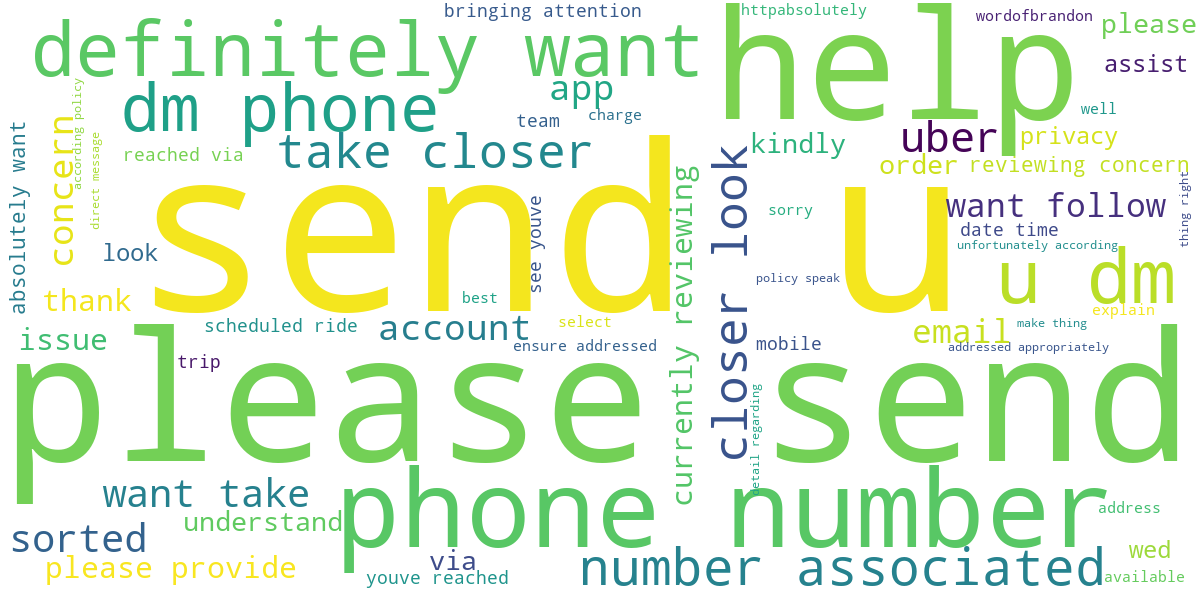

In [42]:
wcloud

In [43]:
LDAvis_prepared = lda(pre_from_uber_df_tk, n_topics=n_topics)

C:\Users\18199\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Topics
[(0, '0.054*"http" + 0.045*"u" + 0.045*"please" + 0.034*"want" + 0.028*"sajanderson" + 0.025*"sorted" + 0.025*"get" + 0.024*"concern" + 0.024*"definitely" + 0.021*"number"'), (1, '0.060*"http" + 0.045*"u" + 0.029*"take" + 0.029*"gaiainma" + 0.029*"esemee" + 0.029*"kindly" + 0.018*"date" + 0.018*"like" + 0.018*"send" + 0.018*"wed"'), (2, '0.063*"please" + 0.057*"http" + 0.052*"dm" + 0.052*"u" + 0.046*"send" + 0.041*"number" + 0.041*"phone" + 0.034*"definitely" + 0.034*"want" + 0.029*"assist"'), (3, '0.066*"http" + 0.027*"u" + 0.027*"help" + 0.020*"want" + 0.020*"definitely" + 0.020*"dodiesue" + 0.020*"jeremycushman" + 0.020*"look" + 0.020*"fee" + 0.020*"gardegar"'), (4, '0.072*"http" + 0.053*"please" + 0.053*"u" + 0.044*"look" + 0.042*"send" + 0.041*"take" + 0.040*"closer" + 0.035*"number" + 0.033*"want" + 0.025*"absolutely"'), (5, '0.065*"http" + 0.033*"want" + 0.033*"dodiesue" + 0.033*"npteggchaser" + 0.033*"available" + 0.017*"u" + 0.017*"help" + 0.017*"currently" + 0.017*"de

In [44]:
LDAvis_prepared

C:\Users\18199\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.138921 -0.056380       1        1  21.336091
8     -0.090929  0.041038       2        1  18.067686
2     -0.090210  0.063428       3        1  15.038154
7      0.014746 -0.032508       4        1   7.960439
3      0.041320 -0.034438       5        1   7.659088
1      0.015011 -0.145605       6        1   7.586727
6     -0.008922  0.085960       7        1   6.063187
5      0.166431 -0.029252       8        1   5.746345
0     -0.001130 -0.014571       9        1   5.508947
9      0.092603  0.122328      10        1   5.033335, topic_info=          Term       Freq      Total Category  logprob  loglift
10        help  27.000000  27.000000  Default  30.0000  30.0000
24        want  27.000000  27.000000  Default  29.0000  29.0000
19  definitely  19.000000  19.000000  Default  28.0000  28.0000
64        take  15.000000  15.000000  Default  27.0000  27.0000
62      closer  13.000000  13.000000  Default  26.0000  26.0000
..         ...        ...        ...      ...      ...      ...
3         http   2.882242  71.649737  Topic10  -2.9444  -0.2241
29       phone   0.773288  23.427429  Topic10  -4.2601  -0.4219
25          dm   0.773280  25.608101  Topic10  -4.2601  -0.5109
28      number   0.773310  27.890046  Topic10  -4.2601  -0.5963
30      please   0.773282  39.573050  Topic10  -4.2601  -0.9462

[453 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
237       4  0.702057        able
61        1  0.840692  absolutely
61        9  0.140115  absolutely
124       2  0.301077   according
124       8  0.301077   according
...     ...       ...         ...
207       2  0.470765      yepwbk
119       2  0.580462       youre
159       2  0.503358       youve
159       4  0.251679       youve
159       5  0.251679       youve

[504 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 9, 3, 8, 4, 2, 7, 6, 1, 10])

In [45]:
pyLDAvis.save_html(LDAvis_prepared,'./html/pre_from_lda_n{}.html'.format(n_topics))

C:\Users\18199\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# From Uber Post-COVID

In [46]:
post_from_uber_df_tk = uber_df_tk[(uber_df_tk['source'] == 'Uber_Support') & (uber_df_tk['created_at'] > covid_date)]

C:\Users\18199\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [47]:
post_from_uber_df_tk

C:\Users\18199\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,source,source_id,target,target_id,type_of_content,created_at,all_data,text
664,Uber_Support,2815754953,fltrtae,1242683484704915457,Reply,2020-10-17 10:27:36,{'created_at': 'Sat Oct 17 10:27:36 +0000 2020...,"[fltrtae, sorry, hear, experience, would, like..."
665,Uber_Support,2815754953,fltrtae,1242683484704915457,Reply,2020-10-17 10:27:36,{'created_at': 'Sat Oct 17 10:27:36 +0000 2020...,"[fltrtae, sorry, hear, experience, would, like..."
666,Uber_Support,2815754953,fltrtae,1242683484704915457,Reply,2020-10-17 10:27:36,{'created_at': 'Sat Oct 17 10:27:36 +0000 2020...,"[fltrtae, sorry, hear, experience, would, like..."
667,Uber_Support,2815754953,fltrtae,1242683484704915457,Reply,2020-10-17 10:27:36,{'created_at': 'Sat Oct 17 10:27:36 +0000 2020...,"[fltrtae, sorry, hear, experience, would, like..."
668,Uber_Support,2815754953,fltrtae,1242683484704915457,Reply,2020-10-17 10:27:36,{'created_at': 'Sat Oct 17 10:27:36 +0000 2020...,"[fltrtae, sorry, hear, experience, would, like..."
...,...,...,...,...,...,...,...,...
5551,Uber_Support,2815754953,CVREENSWORLD,1352048476339761153,Reply,2021-03-31 16:54:36,{'created_at': 'Wed Mar 31 16:54:36 +0000 2021...,"[cvreensworld, hi, cvreeny, happy, help, pleas..."
5552,Uber_Support,2815754953,makaylabez,303867642,Reply,2021-03-31 16:55:35,{'created_at': 'Wed Mar 31 16:55:35 +0000 2021...,"[makaylabez, happy, help, makayla, please, sen..."
5553,Uber_Support,2815754953,ajb_neuk,1344742630731747328,Reply,2021-03-31 16:55:49,{'created_at': 'Wed Mar 31 16:55:49 +0000 2021...,"[ajbneuk, hi, happy, help, please, follow, sup..."
5554,Uber_Support,2815754953,Nezz911,429610920,Reply,2021-03-31 16:57:30,{'created_at': 'Wed Mar 31 16:57:30 +0000 2021...,"[hi, neo, assist]"


In [48]:
wcloud = word_cloud(post_from_uber_df_tk)

C:\Users\18199\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Total words 73797


C:\Users\18199\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


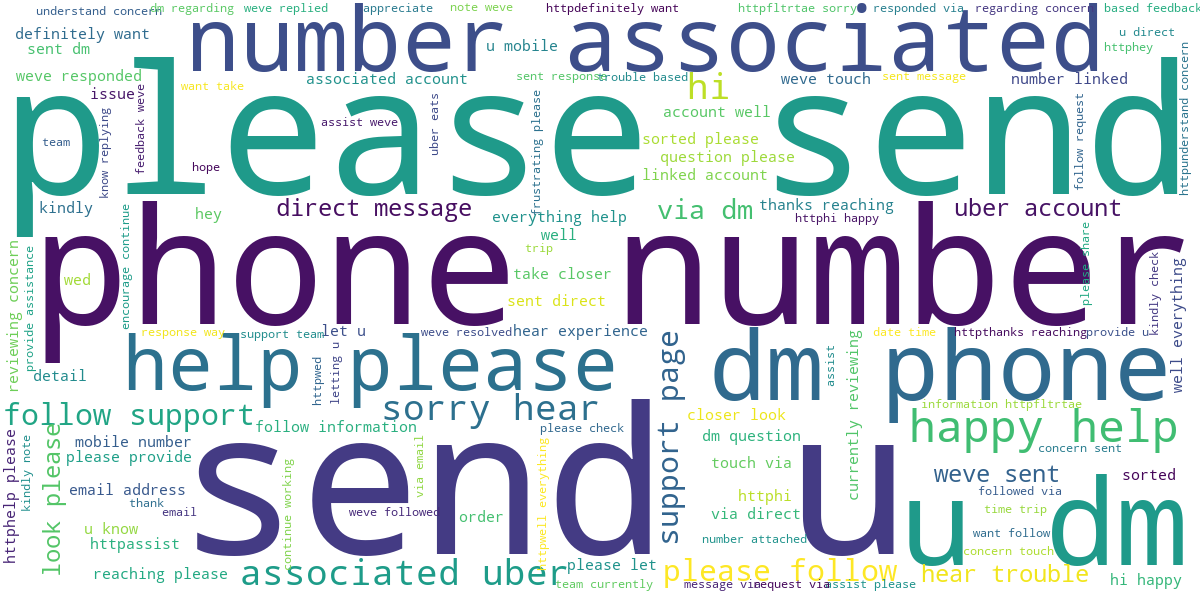

In [49]:
wcloud

In [50]:
LDAvis_prepared = lda(post_from_uber_df_tk, n_topics=n_topics)

C:\Users\18199\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Topics
[(0, '0.086*"http" + 0.029*"currently" + 0.029*"hi" + 0.026*"please" + 0.023*"support" + 0.019*"uber" + 0.019*"assist" + 0.018*"dm" + 0.018*"help" + 0.017*"team"'), (1, '0.075*"http" + 0.064*"please" + 0.060*"dm" + 0.056*"u" + 0.051*"send" + 0.050*"number" + 0.049*"phone" + 0.035*"help" + 0.031*"associated" + 0.022*"uber"'), (2, '0.100*"http" + 0.055*"please" + 0.041*"follow" + 0.036*"u" + 0.030*"help" + 0.028*"hi" + 0.026*"happy" + 0.026*"support" + 0.023*"like" + 0.022*"page"'), (3, '0.069*"http" + 0.049*"please" + 0.031*"dm" + 0.029*"u" + 0.025*"weve" + 0.024*"reaching" + 0.021*"number" + 0.020*"phone" + 0.020*"thanks" + 0.019*"sorry"'), (4, '0.057*"please" + 0.044*"u" + 0.038*"send" + 0.037*"message" + 0.036*"assist" + 0.033*"dm" + 0.032*"via" + 0.030*"http" + 0.028*"phone" + 0.026*"direct"'), (5, '0.048*"http" + 0.032*"please" + 0.031*"u" + 0.031*"assist" + 0.030*"dm" + 0.030*"via" + 0.028*"message" + 0.024*"number" + 0.022*"direct" + 0.021*"send"'), (6, '0.061*"http" + 0.

In [51]:
LDAvis_prepared

C:\Users\18199\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.007965 -0.084582       1        1  22.469562
8      0.024105 -0.067863       2        1  17.278400
2     -0.068595 -0.013541       3        1  12.903405
6      0.043679  0.081744       4        1   8.023875
4      0.089140 -0.016080       5        1   7.942021
3      0.058975  0.050226       6        1   7.644506
5      0.057421  0.005553       7        1   6.829569
0     -0.099368  0.060228       8        1   6.640555
9     -0.077159 -0.004965       9        1   5.405035
7     -0.020233 -0.010720      10        1   4.863071, topic_info=          Term        Freq       Total Category  logprob  loglift
4         http  776.000000  776.000000  Default  30.0000  30.0000
2       follow  151.000000  151.000000  Default  29.0000  29.0000
78      assist  150.000000  150.000000  Default  28.0000  28.0000
84     support  111.000000  111.000000  Default  27.0000  27.0000
48        help  303.000000  303.000000  Default  26.0000  26.0000
..         ...         ...         ...      ...      ...      ...
78      assist    5.362032  150.364610  Topic10  -4.6362  -0.3102
23       phone    6.295513  334.172726  Topic10  -4.4757  -0.9483
18  associated    5.426236  232.832002  Topic10  -4.6243  -0.7356
47  everything    3.605116   35.051346  Topic10  -5.0331   0.7490
2       follow    4.483204  151.759819  Topic10  -4.8152  -0.4985

[734 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
494       7  0.589991       abhisek
480       7  0.798184      abhishek
526       1  0.825770    absolutely
526       7  0.103221    absolutely
299      10  0.567051  accidentally
...     ...       ...           ...
8         8  0.035762         would
8         9  0.071524         would
525       6  0.639631        xolani
72        4  0.287129          zaid
72       10  0.574259          zaid

[1256 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 9, 3, 7, 5, 4, 6, 1, 10, 8])

In [52]:
pyLDAvis.save_html(LDAvis_prepared,'./html/post_from_lda_n{}.html'.format(n_topics))

C:\Users\18199\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Pre-COVID

In [53]:
pre_uber_df_tk = uber_df_tk[uber_df_tk['created_at'] <= covid_date]

C:\Users\18199\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [54]:
pre_uber_df_tk

C:\Users\18199\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,source,source_id,target,target_id,type_of_content,created_at,all_data,text
0,Uber_Support,2815754953,wordofbrandon,2566081240,Reply,2019-08-31 10:53:53,{'created_at': 'Sat Aug 31 10:53:53 +0000 2019...,"[wordofbrandon, thanks, bringing, attention, w..."
1,Uber_Support,2815754953,wordofbrandon,2566081240,Reply,2019-08-31 10:53:53,{'created_at': 'Sat Aug 31 10:53:53 +0000 2019...,"[wordofbrandon, thanks, bringing, attention, w..."
2,Uber_Support,2815754953,CapeVgirl,719534538,Reply,2019-10-01 07:45:30,{'created_at': 'Tue Oct 01 07:45:30 +0000 2019...,"[capevgirl, help, suggest, restarting, app, wo..."
3,Uber_Support,2815754953,CapeVgirl,719534538,Reply,2019-10-01 07:45:30,{'created_at': 'Tue Oct 01 07:45:30 +0000 2019...,"[capevgirl, help, suggest, restarting, app, wo..."
4,SatishInnov8,722043526461145088,Uber_Support,2815754953,Reply,2019-12-09 17:11:51,{'created_at': 'Mon Dec 09 17:11:51 +0000 2019...,"[ubersupport, wish, respectfully, state, regul..."
...,...,...,...,...,...,...,...,...
659,lordsarcastico,141914172,Uber_Support,2815754953,Reply,2019-12-31 23:58:55,{'created_at': 'Tue Dec 31 23:58:55 +0000 2019...,"[ubersupport, hi, uber, still, asking, questio..."
660,lordsarcastico,141914172,Uber,19103481,Reply,2019-12-31 23:58:55,{'created_at': 'Tue Dec 31 23:58:55 +0000 2019...,"[ubersupport, hi, uber, still, asking, questio..."
661,lordsarcastico,141914172,dkhos,41642329,Reply,2019-12-31 23:58:55,{'created_at': 'Tue Dec 31 23:58:55 +0000 2019...,"[ubersupport, hi, uber, still, asking, questio..."
662,Uber_Support,2815754953,matdel69,1237136270767382529,Reply,2020-03-09 22:13:45,{'created_at': 'Mon Mar 09 22:13:45 +0000 2020...,"[absolutely, want, take, closer, look, please,..."


In [55]:
wcloud = word_cloud(pre_uber_df_tk)

C:\Users\18199\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Total words 47522


C:\Users\18199\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


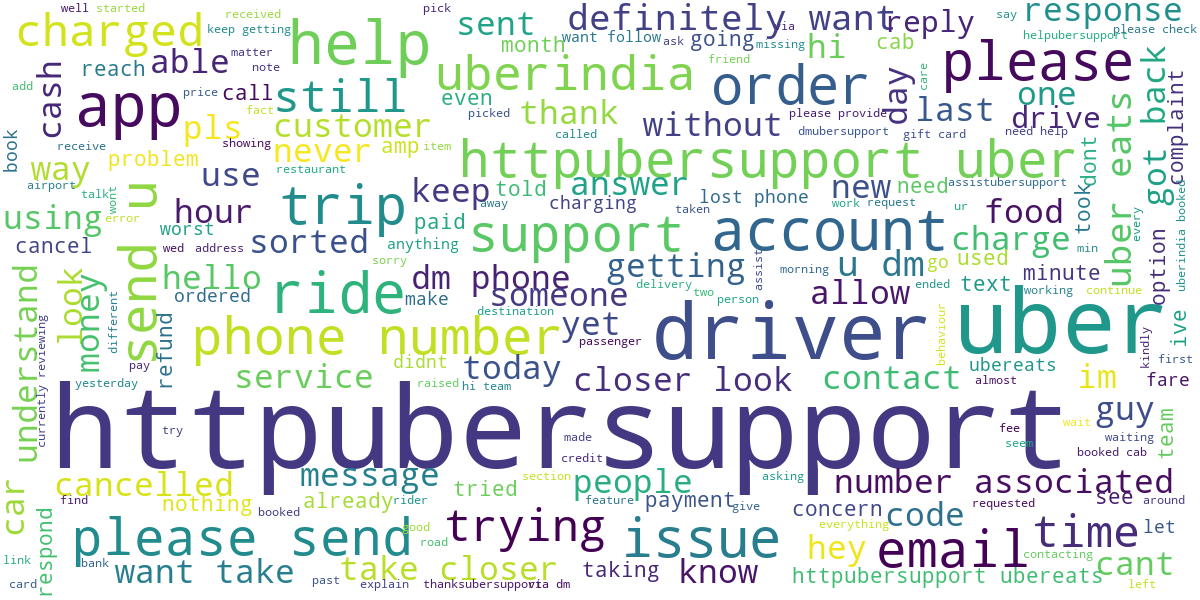

In [56]:
wcloud

In [57]:
LDAvis_prepared = lda(pre_uber_df_tk, n_topics=n_topics)

C:\Users\18199\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Topics
[(0, '0.085*"ubersupport" + 0.057*"http" + 0.042*"uber" + 0.020*"driver" + 0.011*"phone" + 0.010*"trip" + 0.010*"ride" + 0.009*"support" + 0.009*"customer" + 0.008*"please"'), (1, '0.072*"http" + 0.050*"ubersupport" + 0.026*"uber" + 0.019*"help" + 0.019*"please" + 0.018*"send" + 0.017*"u" + 0.014*"want" + 0.014*"phone" + 0.013*"number"'), (2, '0.067*"ubersupport" + 0.062*"http" + 0.016*"uber" + 0.015*"ride" + 0.012*"hi" + 0.011*"issue" + 0.010*"account" + 0.010*"driver" + 0.009*"trying" + 0.008*"call"'), (3, '0.042*"http" + 0.039*"ubersupport" + 0.018*"driver" + 0.017*"help" + 0.017*"ride" + 0.013*"email" + 0.012*"uber" + 0.012*"bluedonkey" + 0.009*"issue" + 0.009*"please"'), (4, '0.063*"http" + 0.062*"ubersupport" + 0.015*"driver" + 0.013*"uber" + 0.011*"app" + 0.011*"u" + 0.009*"help" + 0.008*"already" + 0.008*"please" + 0.007*"ubereats"'), (5, '0.095*"ubersupport" + 0.058*"http" + 0.027*"uber" + 0.016*"trip" + 0.012*"driver" + 0.012*"account" + 0.009*"please" + 0.008*"help" 

In [58]:
LDAvis_prepared

C:\Users\18199\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.041512 -0.028503       1        1  21.244728
1     -0.098911  0.044709       2        1  17.861602
0      0.038503 -0.034044       3        1  13.618990
4      0.011689  0.123233       4        1   8.354567
6     -0.116380 -0.046671       5        1   8.267697
9     -0.054926 -0.041050       6        1   7.385471
2      0.097514 -0.029636       7        1   7.020434
8      0.031588  0.055068       8        1   6.448326
7      0.024798  0.005496       9        1   5.886567
3      0.024613 -0.048602      10        1   3.911617, topic_info=            Term        Freq       Total Category  logprob  loglift
3           http  395.000000  395.000000  Default  30.0000  30.0000
24   ubersupport  465.000000  465.000000  Default  29.0000  29.0000
43             u   51.000000   51.000000  Default  28.0000  28.0000
48         order   37.000000   37.000000  Default  27.0000  27.0000
153         ride   45.000000   45.000000  Default  26.0000  26.0000
..           ...         ...         ...      ...      ...      ...
292      charged    1.586600   20.729192  Topic10  -5.1232   0.6713
144      getting    1.586500   22.187062  Topic10  -5.1233   0.6032
195         trip    1.586571   44.396036  Topic10  -5.1232  -0.0904
210       booked    1.164188   14.477808  Topic10  -5.4328   0.7206
158          cab    1.138851   13.476757  Topic10  -5.4548   0.7703

[681 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
458       1  0.373755     able
458       2  0.053394     able
458       3  0.053394     able
458       5  0.106787     able
458       6  0.106787     able
...     ...       ...      ...
973       3  0.233175       yr
973       4  0.233175       yr
973       6  0.466350       yr
760       4  0.628463  zealand
1012      1  0.613193     über

[1260 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 2, 1, 5, 7, 10, 3, 9, 8, 4])

In [59]:
pyLDAvis.save_html(LDAvis_prepared,'./html/pre_lda_n{}.html'.format(n_topics))

C:\Users\18199\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Post-COVID

In [60]:
post_uber_df_tk = uber_df_tk[uber_df_tk['created_at'] > covid_date]

C:\Users\18199\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [61]:
post_uber_df_tk

C:\Users\18199\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,source,source_id,target,target_id,type_of_content,created_at,all_data,text
664,Uber_Support,2815754953,fltrtae,1242683484704915457,Reply,2020-10-17 10:27:36,{'created_at': 'Sat Oct 17 10:27:36 +0000 2020...,"[fltrtae, sorry, hear, experience, would, like..."
665,Uber_Support,2815754953,fltrtae,1242683484704915457,Reply,2020-10-17 10:27:36,{'created_at': 'Sat Oct 17 10:27:36 +0000 2020...,"[fltrtae, sorry, hear, experience, would, like..."
666,Uber_Support,2815754953,fltrtae,1242683484704915457,Reply,2020-10-17 10:27:36,{'created_at': 'Sat Oct 17 10:27:36 +0000 2020...,"[fltrtae, sorry, hear, experience, would, like..."
667,Uber_Support,2815754953,fltrtae,1242683484704915457,Reply,2020-10-17 10:27:36,{'created_at': 'Sat Oct 17 10:27:36 +0000 2020...,"[fltrtae, sorry, hear, experience, would, like..."
668,Uber_Support,2815754953,fltrtae,1242683484704915457,Reply,2020-10-17 10:27:36,{'created_at': 'Sat Oct 17 10:27:36 +0000 2020...,"[fltrtae, sorry, hear, experience, would, like..."
...,...,...,...,...,...,...,...,...
5563,ajb_neuk,1344742630731747328,Uber_Support,2815754953,Reply,2021-03-31 17:15:48,{'created_at': 'Wed Mar 31 17:15:48 +0000 2021...,"[ubersupport, yeah, cause, link, useful, suppo..."
5564,AdrianMatache7,1376698104028794882,Uber_Support,2815754953,Reply,2021-03-31 17:18:34,{'created_at': 'Wed Mar 31 17:18:34 +0000 2021...,"[ubersupport, hi, guy, long, take, bank, accou..."
5565,k_sovs,1369169148580823040,Uber_Support,2815754953,Reply,2021-03-31 17:19:01,{'created_at': 'Wed Mar 31 17:19:01 +0000 2021...,"[ubersupport, filled, form, many, time, response]"
5566,MY0U1SANA,918655647763324928,Uber_Support,2815754953,Reply,2021-03-31 17:22:01,{'created_at': 'Wed Mar 31 17:22:01 +0000 2021...,"[ubersupport, fltrtae, hold]"


In [62]:
wcloud = word_cloud(post_uber_df_tk)

C:\Users\18199\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Total words 320617


C:\Users\18199\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


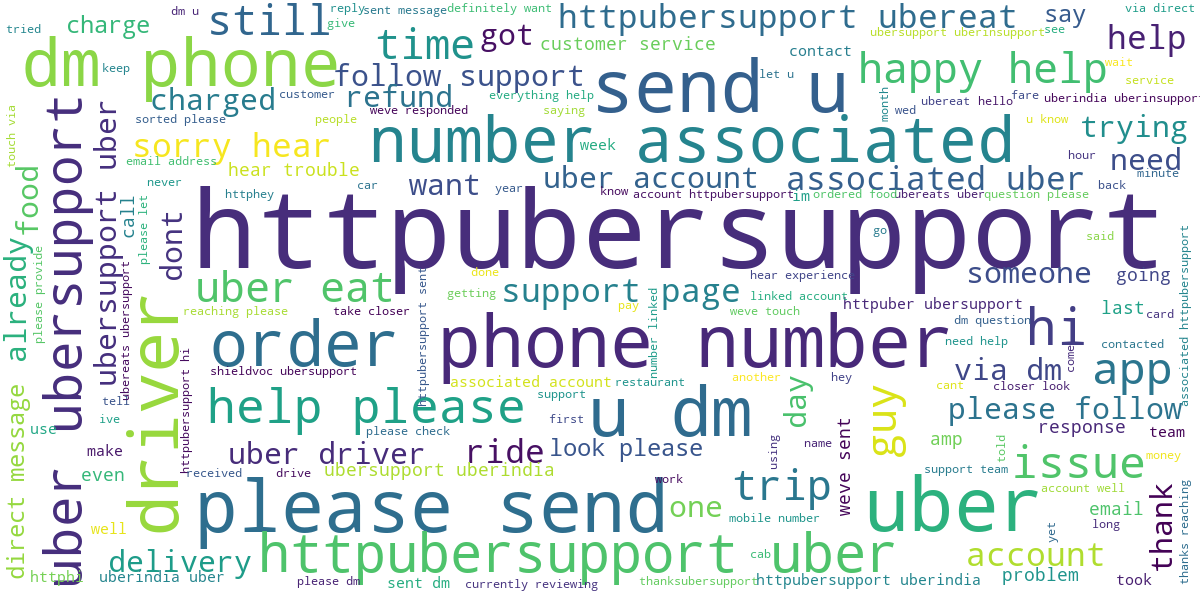

In [63]:
wcloud

In [64]:
LDAvis_prepared = lda(post_uber_df_tk, n_topics=n_topics)

C:\Users\18199\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Topics
[(0, '0.116*"ubersupport" + 0.065*"http" + 0.038*"uber" + 0.015*"help" + 0.013*"dm" + 0.013*"driver" + 0.010*"account" + 0.009*"please" + 0.008*"sent" + 0.007*"still"'), (1, '0.076*"ubersupport" + 0.063*"http" + 0.048*"uber" + 0.018*"driver" + 0.012*"ride" + 0.010*"uberindia" + 0.007*"message" + 0.006*"response" + 0.006*"customer" + 0.006*"get"'), (2, '0.065*"http" + 0.057*"ubersupport" + 0.019*"order" + 0.016*"please" + 0.015*"ubereats" + 0.014*"u" + 0.013*"dm" + 0.013*"sent" + 0.011*"uber" + 0.009*"hey"'), (3, '0.078*"ubersupport" + 0.068*"http" + 0.052*"uber" + 0.024*"driver" + 0.017*"uberindia" + 0.015*"help" + 0.013*"support" + 0.009*"please" + 0.007*"get" + 0.007*"hi"'), (4, '0.064*"http" + 0.050*"ubersupport" + 0.038*"please" + 0.025*"u" + 0.023*"send" + 0.018*"dm" + 0.016*"phone" + 0.014*"number" + 0.013*"associated" + 0.012*"trip"'), (5, '0.079*"http" + 0.045*"ubersupport" + 0.043*"please" + 0.033*"number" + 0.033*"uber" + 0.032*"u" + 0.029*"dm" + 0.028*"phone" + 0.027

In [65]:
LDAvis_prepared

C:\Users\18199\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.024152  0.029136       1        1  22.717576
5      0.135926  0.011102       2        1  18.228927
3     -0.039634  0.040005       3        1  10.868484
2      0.055053 -0.010237       4        1   7.944605
7     -0.052134  0.089082       5        1   7.778302
4      0.104923 -0.002374       6        1   7.398817
8     -0.056986 -0.072001       7        1   7.035409
6     -0.006717 -0.049991       8        1   6.623008
1     -0.060724  0.025274       9        1   6.577070
9     -0.055554 -0.059996      10        1   4.827803, topic_info=            Term         Freq        Total Category  logprob  loglift
31          uber  1598.000000  1598.000000  Default  30.0000  30.0000
63   ubersupport  3457.000000  3457.000000  Default  29.0000  29.0000
25          send   345.000000   345.000000  Default  28.0000  28.0000
24        please   774.000000   774.000000  Default  27.0000  27.0000
4           http  2959.000000  2959.000000  Default  26.0000  26.0000
..           ...          ...          ...      ...      ...      ...
48          help    11.997678   549.818860  Topic10  -5.2251  -0.7941
226     customer     8.422156   131.953149  Topic10  -5.5790   0.2792
11           get     9.053801   273.389226  Topic10  -5.5067  -0.3769
131      support     8.829466   289.881533  Topic10  -5.5318  -0.4606
254    uberindia     8.581385   276.777417  Topic10  -5.5603  -0.4428

[795 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
2135      4  0.705884  abkgardner
194       1  0.451236        able
194       2  0.075206        able
194       3  0.094008        able
194       4  0.150412        able
...     ...       ...         ...
209      10  0.148109       worst
1850      4  0.244913          yr
1850      8  0.489827          yr
2816      3  0.649103        zoom
2816      6  0.216368        zoom

[2061 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 6, 4, 3, 8, 5, 9, 7, 2, 10])

In [66]:
pyLDAvis.save_html(LDAvis_prepared,'./html/post_lda_n{}.html'.format(n_topics))

C:\Users\18199\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
